## Infos ( à supprimer ensuite)

## Variables à ajouter issues des recherches biblio ( à supprimer ensuite)

Variable(s): 

- Population des pays représentés 
- Variable indiquant si le pays est communiste ou pas 
- Variable indiquant si le pays est stable ou pas 
- Variable indiquant si le pays est émergeant ou pas ( otherwise pauvre , riche à peaufiner par la suite) 
- Variable indiquant si le pays a la culture du sport ou pas. 
- Variable indiquant le PIB par habitant 
- Variable indiquant les financements alloués aux sports (olympiques ou pas)


Il faut créer le train et le test avec des données 2024 , il faut les construire , il faut aussi savoir traiter le fait que cette fois ci la Russie ne sera pas disponible .
Faire indice : pays perturbé 1 avec Russie par exemple ou bien on enlève la Russie  (contexte géopolitique simple, on tah les années où j'ai eu un pb )

But c'est de prédire le nombre de médailles pour chaque pays , indicateur simple 
EXTRA POUR AVOIR 20 : Attribuer un poid aux médailles -> pour potentiellement savoir le nb d'or , argent , bronze

Attention au COVID 19 , influence public , web scrapping sur 30 ans de tous les pays qui ont organisé les jeux 
Attention aux pays pas autorisés à concourir 
Pays en guerre qui envoient moins d'athlètes 
Ukraine 
Palestine 
Iles caiman -> doivent être rattachées à un pays 

JO hiver 
JO été Corrélation 
Apparition des femmes dans les JO ( échantillonnage ) 

Culture du sport : Comment la créer ? 
Budget alloué aux sports (investissement , infrastructures ... ) 
Nb de professionnels 
Nb de licencés 
Nb de sports olympiques disponibles à l'école 

Variable : Pays Communiste ou pas 

Croissance pays économique 

Athlète à partir de 25 ans il n'a plus le niveau : on commence à partir de 2000 , JO Sydney 

Indice dvp des pays à recevoir 

Variable pays organisateur 

Sport qui ont des gens avec un âge bien définie (exemple skate Japonais c'est que des jeunes <= 18 ans)

Dataset coupes mondes de discipline  
    
Variable Note selon l'âge 

Athlète qui sont comptés comme participant à deux pays 

Variable : religion majoritaire pays 

Espérance de vie par pays 
Variable pays dvp ou pas 


Recupérer données JO 2018 et 2021

Variable Poids par Médailles : échelloner les JO de 1 à 10 pour 
Variable Poids par année : 

# Introduction  (Business Understanding) 

## Détermination objectifs métier , analytique du projet 

## Identifier les contraintes , limites et risque du projet

## Chargement des packages si besoin 

In [324]:
%load_ext ipython_memory_usage 

The ipython_memory_usage extension is already loaded. To reload it, use:
  %reload_ext ipython_memory_usage
In [324] used 0.0 MiB RAM in 0.10s (system mean cpu 5%, single max cpu 15%), peaked 0.0 MiB above final usage, current RAM usage now 486.3 MiB


In [325]:
 #!pip install ydata_profiling

In [325] used 0.0 MiB RAM in 0.10s (system mean cpu 8%, single max cpu 88%), peaked 0.0 MiB above final usage, current RAM usage now 486.3 MiB


In [326]:
#%imu_stop

In [326] used 0.0 MiB RAM in 0.10s (system mean cpu 10%, single max cpu 83%), peaked 0.0 MiB above final usage, current RAM usage now 486.3 MiB


## Importation des librairies 

In [327]:
from ydata_profiling import ProfileReport

In [327] used 0.0 MiB RAM in 0.10s (system mean cpu 8%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 486.3 MiB


In [328]:
import pandas as pd
import numpy as np
import ipython_memory_usage.ipython_memory_usage as imu
from describe_csv import *  # charge le fichier describe_csv.py par chunk de 10 000 (10**4)

import math
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import scipy as sp
import scipy.stats
from pivottablejs import pivot_ui
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline, make_union
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

imu.start_watching_memory() 

In [328] used 0.0 MiB RAM in 0.10s (system mean cpu 8%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 486.3 MiB


# CODE  

## Bases de données disponibles 

In [329]:
# df_athlète=
#df_region=
#df_dictionnary=

In [329] used 0.0 MiB RAM in 0.10s (system mean cpu 4%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 486.4 MiB


## Optimisation des datasets
   Dans un souci d'optimisation de l'espace mémoire occupé, nous allons faire en sorte d'optimiser les différents dataframe que nous utilisons. 
Pour mener à bien ceci, nous allons des fonctions contenues dans `describe_csv.py`, en les améliorant pour automatiser le processus.

In [330]:
#Code

In [330] used 0.0 MiB RAM in 0.10s (system mean cpu 8%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 486.4 MiB


In [331]:
def optimize_data_types(df):
    """
    Optimize data types of columns in a pandas DataFrame.

    Parameters:
        df (pandas.DataFrame): Input DataFrame.

    Returns:
        pandas.DataFrame: DataFrame with optimized data types.
    """
    optimized_df = df.copy()
    
    for col in optimized_df.columns:
        col_dtype = optimized_df[col].dtype
        
        if col_dtype == 'object':
            # Convert object type columns to category if unique values are less than 50% of total rows
            if len(optimized_df[col].unique()) / len(optimized_df[col]) < 0.5:
                optimized_df[col] = optimized_df[col].astype('category')
        elif col_dtype == 'int64':
            # Convert int64 to smaller integer types if possible
            optimized_df[col] = pd.to_numeric(optimized_df[col], downcast='integer', errors='coerce')
        elif col_dtype == 'float64':
            # Convert float64 to smaller floating point types if possible
            optimized_df[col] = pd.to_numeric(optimized_df[col], downcast='float', errors='coerce')
        elif col_dtype == 'bool':
            # Convert boolean columns to integer type
            optimized_df[col] = optimized_df[col].astype('int8')

    return optimized_df

In [331] used 0.0 MiB RAM in 0.10s (system mean cpu 8%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 486.4 MiB


In [332]:
#df_test['Age'] = pd.to_numeric(df_test['Age'], errors='coerce', downcast='integer')

# Convert 'Height' and 'Weight' columns to int16
#df_test['Height'] = pd.to_numeric(df_test['Height'], errors='coerce', downcast='integer')
#df_test['Weight'] = pd.to_numeric(df_test['Weight'], errors='coerce', downcast='integer')

In [332] used 0.0 MiB RAM in 0.10s (system mean cpu 6%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 486.4 MiB


In [333]:
#### Code Nathan si tu veux rajouter 

In [333] used 0.0 MiB RAM in 0.10s (system mean cpu 9%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 486.4 MiB


### Modification des noms pays ... (Code Guillaume)

In [334]:
df=pd.read_csv('data/data_FLO_without_NaN.csv',sep=',')

In [334] used 10.7 MiB RAM in 0.27s (system mean cpu 13%, single max cpu 100%), peaked 17.4 MiB above final usage, current RAM usage now 497.1 MiB


In [335]:
# Normalisation pour une cohérence des données (pas de notion politique ici)

# # RUSSIA
df.loc[(df['Team'] == 'Soviet Union') & (df['NOC'] == 'URS'), ['Team', 'NOC']] = ['Russia', 'RUS'] # URSS période 1952-1988

# # GERMANY
# df.loc[(df['Team'] == 'East Germany') & (df['NOC'] == 'GDR'), ['Team', 'NOC']] = ['Germany', 'GER']

# CHINA
df.loc[df['Team'] == "People's Republic of China", ['Team', 'NOC']] = ['China', 'CHN']

# UNITED STATES
df.loc[df['Team'] == "United States of America", ['Team', 'NOC']] = ['United States', 'USA']

In [335] used 0.4 MiB RAM in 0.12s (system mean cpu 8%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 497.5 MiB


In [ ]:
import pandas as pd

# Votre DataFrame df doit être déjà défini

# Votre dictionnaire de correspondance
country_mapping = {
    'Indonesia-1': 'Indonesia',
    'Nigeria-2': 'Nigeria',
    'Brazil-1': 'Brazil',
    'Spain-2': 'Spain',
    'Brazil-2': 'Brazil',
    'Russia-2': 'Russia',
    'Japan-1': 'Japan',
    'Australia-2': 'Australia',
    'Greece-1': 'Greece',
    'Greece-2': 'Greece',
    'Japan-2': 'Japan',
    'Sweden-2': 'Sweden',
    'Belarus-1': 'Belarus',
    'Germany-2': 'Germany',
    'Great Britain-1': 'United Kingdom',
    'United States-1': 'United States',
    'United States-2': 'United States',
    'Canada-1': 'Canada',
    'Spain-1': 'Spain',
    'Australia-1': 'Australia',
    'Germany-1': 'Germany',
    'Romania-1': 'Romania',
    'Switzerland-2': 'Switzerland',
    'Czech Republic-2': 'Czech Republic',
    'France-2': 'France',
    'Czech Republic-1': 'Czech Republic',
    'Canada-2': 'Canada',
    'Austria-1': 'Austria',
    'India-1': 'India',
    'Sweden-1': 'Sweden',
    'Great Britain-2': 'United Kingdom',
    'Netherlands-2': 'Netherlands',
    'Ukraine-2': 'Ukraine',
    'Italy-1': 'Italy',
    'Netherlands-1': 'Netherlands',
    'Indonesia-2': 'Indonesia',
    'China-2': 'China',
    'China-1': 'China',
    'Argentina-1': 'Argentina',
    'Argentina-2': 'Argentina',
    'Italy-2': 'Italy',
    'Malaysia-1': 'Malaysia',
    'South Korea-2': 'South Korea',
    'Hong Kong-1': 'Hong Kong',
    'Switzerland-1': 'Switzerland',
    'Malaysia-2': 'Malaysia',
    'Cuba-1': 'Cuba',
    'Hungary-1': 'Hungary',
    'France-1': 'France',
    'Poland-2': 'Poland',
    'Austria-2': 'Austria',
    'Serbia-2': 'Serbia',
    'Nigeria-1': 'Nigeria',
    'Denmark-2': 'Denmark',
    'Cuba-2': 'Cuba',
    'Poland-1': 'Poland',
    'Norway-2': 'Norway',
    'Belarus-2': 'Belarus',
    'Norway-1': 'Norway',
    'Slovakia-2': 'Slovakia',
    'Denmark-1': 'Denmark',
    'South Korea-1': 'South Korea',
    'Singapore-2': 'Singapore',
    'Russia-1': 'Russia',
    'Hong Kong-2': 'Hong Kong',
    'Ukraine-1': 'Ukraine',
    'Slovenia-1': 'Slovenia',
    'Slovakia-1': 'Slovakia',
    'Hungary-2': 'Hungary',
    'Slovenia-2': 'Slovenia',
    'Romania-2': 'Romania',
    'Thailand-1': 'Thailand',
    'India-2': 'India',
    'Thailand-2': 'Thailand',
    'Latvia-1': 'Latvia',
    'Latvia-2': 'Latvia',
    'Singapore-1': 'Singapore',
    'Serbia-1': 'Serbia',
    'China-3': 'China'
}

# Appliquer la normalisation sur la colonne 'Team'
df['Team'] = df['Team'].map(lambda x: country_mapping.get(x, x))

# Afficher le DataFrame mis à jour
print(df)


### Traitement des équipes (1 équipe = 1 médaille, pas x médailels par athlete)

si on peux trouver, par exemple si dans une même Team, dans un même Event et dans la même Year, le même Sex, plusieurs personne ont une médaille pour une unique Event, alors cela signifie que c'est un sport collectif (chacun a eu une medaille), mais en réalite cela compte comme une médaille car c'est l'équipe qui est comptabilisé comme une médaille

In [336]:
# Grouper les données par équipe, événement, année et sexe, puis compter le nombre de médailles pour chaque groupe
grouped = df.groupby(['Team', 'Event', 'Year', 'Sex'])['Medal'].count().reset_index()

# Filtrer les groupes où le nombre de médailles est supérieur à 1
sports_collectifs = grouped[grouped['Medal'] > 1]

# Obtenir une liste des événements collectifs
events_collectifs = sports_collectifs['Event'].unique()

# Créer une nouvelle colonne dans le DataFrame pour indiquer si un événement est collectif ou individuel
df['Type_sport'] = df['Event'].apply(lambda x: 'Collectif' if x in events_collectifs else 'Solo')
print(df[['Event', 'Type_sport']])

                                           Event Type_sport
0                                            NaN       Solo
1                                            NaN       Solo
2                                            NaN       Solo
3                                            NaN       Solo
4                                            NaN       Solo
...                                          ...        ...
78768                Volleyball Men's Volleyball  Collectif
78769  Wrestling Men's Welterweight, Greco-Roman       Solo
78770  Wrestling Men's Welterweight, Greco-Roman       Solo
78771      Shooting Women's Air Rifle, 10 metres  Collectif
78772         Athletics Men's 20 kilometres Walk  Collectif

[78773 rows x 2 columns]
In [336] used 6.9 MiB RAM in 0.65s (system mean cpu 8%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 504.4 MiB


In [359]:
# BON APRES JSP COMMENT FAIRE NSM

In [359] used 0.0 MiB RAM in 0.10s (system mean cpu 3%, single max cpu 14%), peaked 0.0 MiB above final usage, current RAM usage now 529.2 MiB


In [338]:
#df['NOC'] = df['NOC'].replace(['Soviet Union', 'URS'], 'RUS')

#df['Team'] = df['Team'].replace(['Soviet Union', 'URS'], 'Russia')
#df['Team'] = df['Team'].replace(['East Germany'], 'Germany')

In [338] used 0.0 MiB RAM in 0.10s (system mean cpu 6%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 504.4 MiB


In [339]:
#df_athlete=df_athlete.query(" NOC !='ROC' and NOC != 'UNK' ") 
#df_regions=df_regions.query(" NOC != 'ROT' and NOC != 'UNK' ")


In [339] used 0.0 MiB RAM in 0.10s (system mean cpu 7%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 504.4 MiB


Suppression refugiés , vous avez pas de pays lol ... et UNK c'est UNK ou encore une autre appelation de refugiés jsp plus 

In [340]:
#df_regions['Country']=df_regions['Country'].fillna('Tuvalu') 

In [340] used 0.0 MiB RAM in 0.10s (system mean cpu 4%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 504.4 MiB


Le tuvalu n'avait pas de NOC

### Modification noms variables 

In [341]:
#df_regions=df_regions.rename(columns={'region':'Country'}) 
#df_dictionnary=df_dictionnary.rename(columns={'GDP per Capita':'PIB/habitant','Code':'NOC'})


In [341] used 0.0 MiB RAM in 0.10s (system mean cpu 6%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 504.4 MiB


### Chargement de la base de données commune  ( On va fusionner mais faut avoir changé les petits couak des 3 df) 

In [342]:
# Code 

In [342] used 0.0 MiB RAM in 0.10s (system mean cpu 5%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 504.4 MiB


In [343]:
# df=pd.merge(pd.merge(df_athlete,df_dictionnary,on='Country'how='left'),df_region,on='Country',how='left')

In [343] used 0.0 MiB RAM in 0.10s (system mean cpu 7%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 504.4 MiB


### Attribution score et poids médaille (Code Noé )

## Traitement des valeurs manquantes 

Effectivement notre base de données possède de nombreuses valeurs manquantes 

In [344]:
# df.isna().sum()

In [344] used -0.0 MiB RAM in 0.10s (system mean cpu 8%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 504.4 MiB


In [345]:
### Première solution : Web Scrapping (code Nathan + FLO)

In [345] used 0.0 MiB RAM in 0.10s (system mean cpu 10%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 504.4 MiB


# Data understanding

## EDA (graph, pivot table ,Matrix confusion...)

In [346]:
# df=pd.read_csv('data/data_FLO_without_NaN.csv',sep=',')

In [346] used -0.0 MiB RAM in 0.10s (system mean cpu 9%, single max cpu 54%), peaked 0.0 MiB above final usage, current RAM usage now 504.3 MiB


### EDA via pivottablejs

In [347]:
# pivot_ui(df)

In [347] used 0.0 MiB RAM in 0.10s (system mean cpu 7%, single max cpu 86%), peaked 0.0 MiB above final usage, current RAM usage now 504.3 MiB


In [348]:
# profile = ProfileReport(df, title='Pandas Profiling Report')
# profile.to_file("report-profiling-test.html")

In [348] used 0.0 MiB RAM in 0.10s (system mean cpu 2%, single max cpu 29%), peaked 0.0 MiB above final usage, current RAM usage now 504.3 MiB


### Target =  Medals --> Nous allons construire des représentations graphiques nous permettant d'observer les Medals en fonction d'autres variables.


In [349]:
df = df[df['Medal'] != 'Pas_medaille']


In [349] used 1.4 MiB RAM in 0.11s (system mean cpu 6%, single max cpu 43%), peaked 0.0 MiB above final usage, current RAM usage now 505.8 MiB


In [350]:
# TRAITER AGE NULL (moyenne des ages)
df['Age'] = df['Age'].fillna(df['Age'].mean())

# TRAITER HEIGHT NULL (moyenne des heights)
df['Height'] = df['Height'].fillna(df.groupby('Sex')['Height'].transform('mean'))

# TRAITER WEIGHT NULL (moyenne des weights)
df['Weight'] = df['Weight'].fillna(df.groupby('Sex')['Weight'].transform('mean'))

# TRAITER SEASON NULL (0 si null, 1 sinon)
df['Season'] = np.where(df['Season'].isnull(), 0, 1)

# TRAITER AGE GROUP
df['AgeGroup'] = pd.cut(df.Age, bins=range(0, 81, 10), right=True)

# TRAITER WEIGHT GROUP
df['WeightGroup'] = pd.cut(df.Weight, bins=range(0, 215, 20), right=True)

# TRAITER HEIGHT GROUP
df['HeightGroup'] = pd.cut(df.Height, bins=range(100, 227, 20), right=True)

# On regroupe les données : par medals/no-medals
survivors = df[df.Medal == True]  # 1
non_survivors = df[df.Medal == True]  # 0


In [350] used 0.3 MiB RAM in 0.11s (system mean cpu 4%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 506.0 MiB


In [351]:
attrs = ['Sex', 'AgeGroup', 'HeightGroup', 'WeightGroup'] # attrs permet de sélectionner les colonnes à afficher

In [351] used 0.0 MiB RAM in 0.10s (system mean cpu 8%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 506.0 MiB


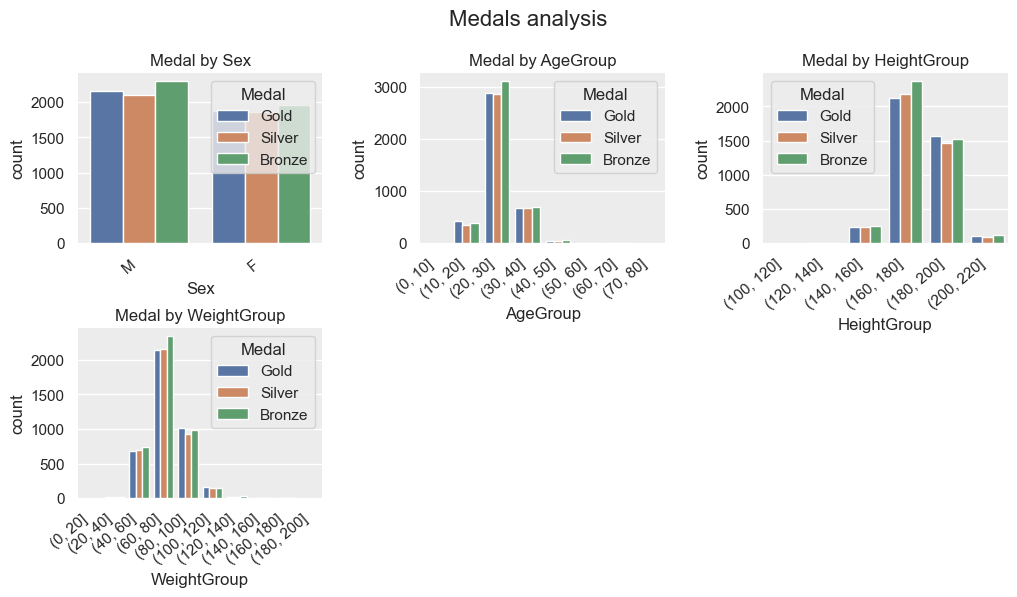

In [352] used 3.9 MiB RAM in 0.62s (system mean cpu 11%, single max cpu 100%), peaked 6.0 MiB above final usage, current RAM usage now 509.9 MiB


In [352]:
# EDA avec Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="dark")

figure = plt.figure(figsize=(12, 8))
figure.suptitle('Medals analysis', fontsize=16)
plt.rc('axes', facecolor='#ececec', edgecolor='none', axisbelow=True, grid=True)
plt.rc('grid', color='w', linestyle='solid')
# Add spacing between subplots
plt.subplots_adjust(top=0.9, bottom=0.05, hspace=0.5, wspace=0.4)  # Adjust bottom value to create more space

for i, col in enumerate(attrs):
    plt.subplot(3, 3, i+1)  # Adjust the subplot parameters according to the number of attributes
    plt.xticks(rotation=40, horizontalalignment='right')
    sns.countplot(x=col, hue='Medal', data=df).set_title('Medal by '+col)

plt.show()


Number of events in each sport over years [Heatmap]

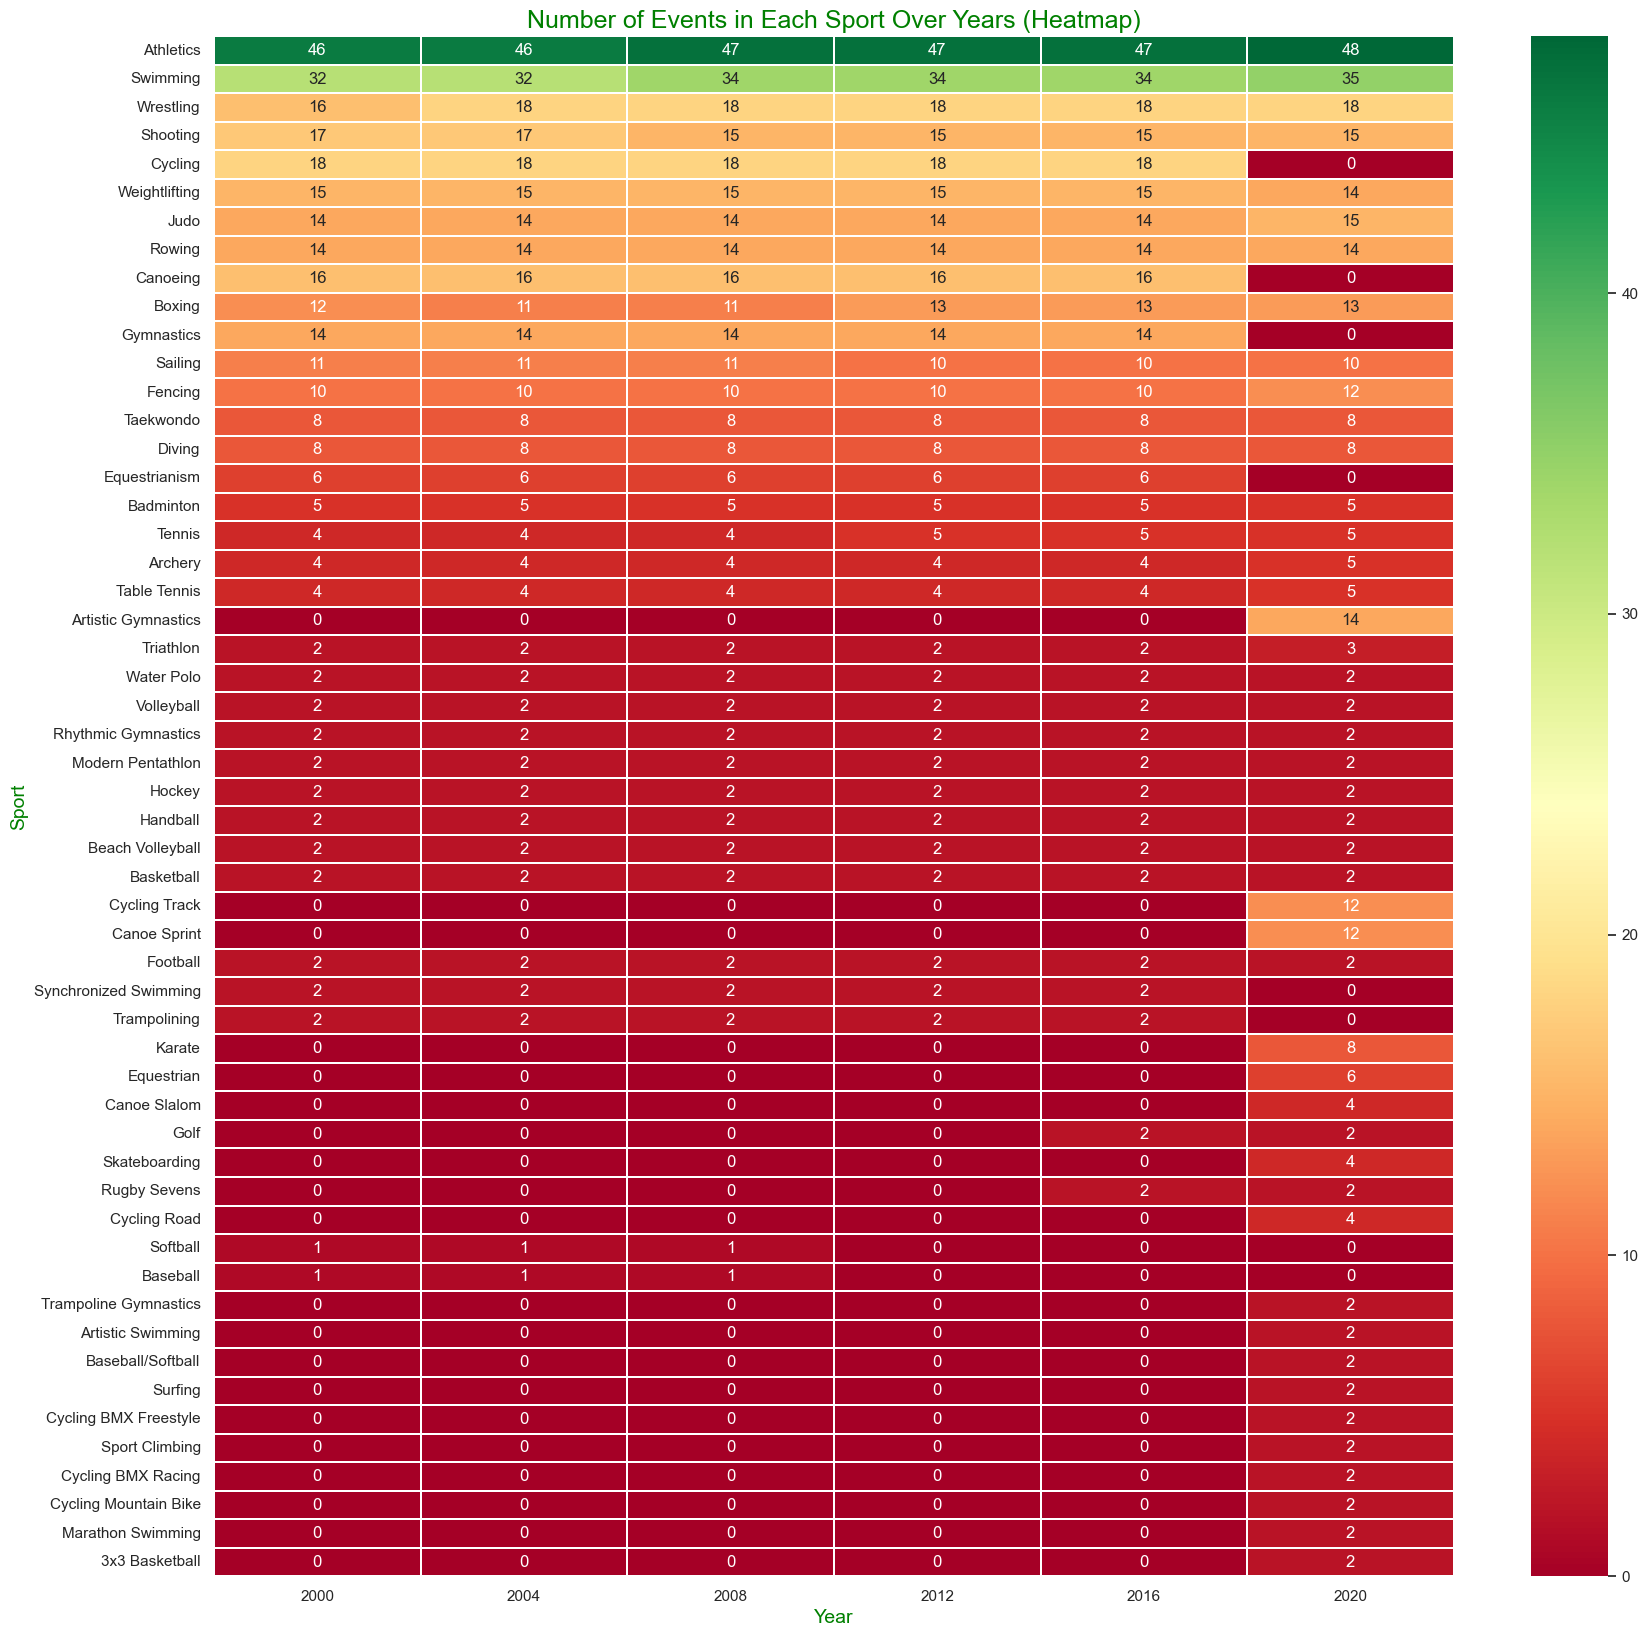

In [353] used 14.4 MiB RAM in 0.75s (system mean cpu 5%, single max cpu 100%), peaked 25.5 MiB above final usage, current RAM usage now 524.3 MiB


In [353]:
sport_year = df.pivot_table(index='Sport', columns='Year', values='Event', aggfunc=lambda x: len(x.unique()))
sport_year.fillna(0, inplace=True)
sport_year = sport_year.reindex(sport_year.sum(axis=1).sort_values(ascending=False).index)

# Affichage de la heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(sport_year, annot=True, linewidths=0.05, cmap="RdYlGn")
plt.xlabel('Year', size=14, color="green")
plt.ylabel('Sport', size=14, color="green")
plt.title('Number of Events in Each Sport Over Years (Heatmap)', size=18, color="green")
plt.show()


Ratio Médailles/Athlete durant les JO

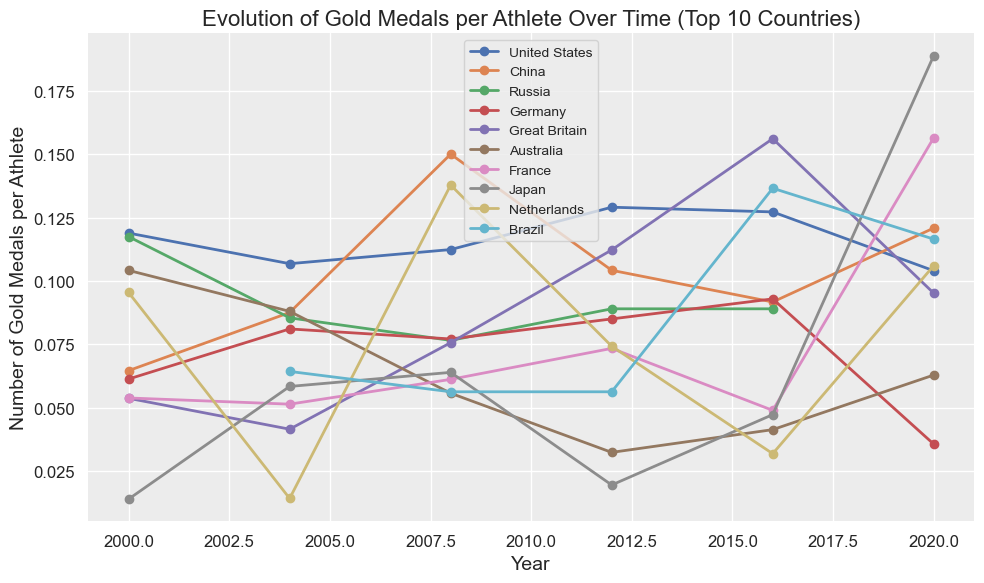

In [357] used -2.4 MiB RAM in 0.37s (system mean cpu 8%, single max cpu 100%), peaked 2.3 MiB above final usage, current RAM usage now 529.2 MiB


In [357]:
import matplotlib.pyplot as plt

# Calculate the total number of athletes per country
total_athletes_per_country = df.groupby('Team')['Name'].nunique()

# Filter the data to include only gold medal winners
gold_medals = df[df['Medal'] == 'Gold']

# Group the data by year and count the number of gold medals won each year for each country
gold_medals_by_year_and_country = gold_medals.groupby(['Year', 'Team'])['Medal'].count().unstack()

# Calculate the number of gold medals per athlete for each country and each year
gold_medals_per_athlete = gold_medals_by_year_and_country.div(total_athletes_per_country, axis=1)

# Select the top 10 countries with the most gold medals overall
top_10_countries = gold_medals.groupby('Team')['Medal'].count().nlargest(10).index

# Plotting the curve for the evolution of gold medals per athlete over time for the top 10 countries
plt.figure(figsize=(10, 6))  # Taille de la figure

for country in top_10_countries:
    plt.plot(gold_medals_per_athlete.index, gold_medals_per_athlete[country], 
             marker='o', markersize=6, linewidth=2, label=country)  # Courbe pour chaque pays avec la légende

plt.title('Evolution of Gold Medals per Athlete Over Time (Top 10 Countries)', fontsize=16)  # Titre
plt.xlabel('Year', fontsize=14)  # Étiquette de l'axe x
plt.ylabel('Number of Gold Medals per Athlete', fontsize=14)  # Étiquette de l'axe y
plt.xticks(fontsize=12)  # Taille de la police des étiquettes de l'axe x
plt.yticks(fontsize=12)  # Taille de la police des étiquettes de l'axe y

plt.grid(True)  # Afficher la grille
plt.legend(fontsize=10)  # Ajouter la légende
plt.tight_layout()  # Ajuster la mise en page
plt.show()


Total Number of Medals Won by Country and Medal Type

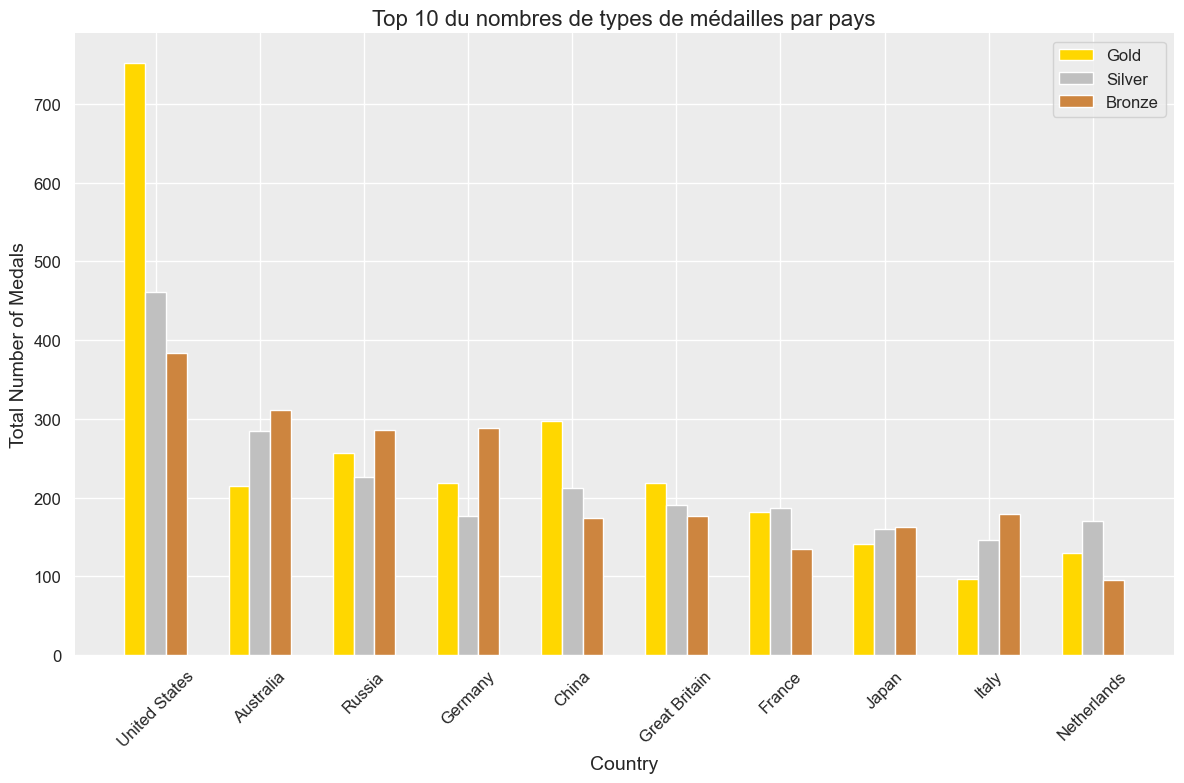

In [354] used 4.0 MiB RAM in 0.31s (system mean cpu 7%, single max cpu 100%), peaked 3.7 MiB above final usage, current RAM usage now 528.3 MiB


In [354]:
import matplotlib.pyplot as plt
import numpy as np

# Group the data by country and count the total number of medals won by each country and each type of medal
medals_by_country = df.groupby(['Team', 'Medal']).size().unstack(fill_value=0)

# Select the top 10 countries with the most total medals
top_10_countries = medals_by_country.sum(axis=1).nlargest(10).index

# Select the medal types
medal_types = ['Gold', 'Silver', 'Bronze']

# Set the position of each bar on the x-axis
x = np.arange(len(top_10_countries))

# Set the width of the bars
width = 0.2

# Assign colors to each medal type
colors = {'Gold': 'gold', 'Silver': 'silver', 'Bronze': 'peru'}

# Plotting the grouped bar graph
plt.figure(figsize=(12, 8))  # Taille de la figure

for i, medal in enumerate(medal_types):
    plt.bar(x - width + i * width, medals_by_country.loc[top_10_countries, medal], 
            width=width, label=medal, color=colors[medal])

plt.title('Top 10 du nombres de types de médailles par pays', fontsize=16)  # Titre
plt.xlabel('Country', fontsize=14)  # Étiquette de l'axe x
plt.ylabel('Total Number of Medals', fontsize=14)  # Étiquette de l'axe y
plt.xticks(ticks=x, labels=top_10_countries, rotation=45, fontsize=12)  # Étiquettes de l'axe x
plt.yticks(fontsize=12)  # Taille de la police des étiquettes de l'axe y

# Supprimer les bordures de la figure
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(fontsize=12)  # Ajouter la légende
plt.tight_layout()  # Ajuster la mise en page
plt.show()


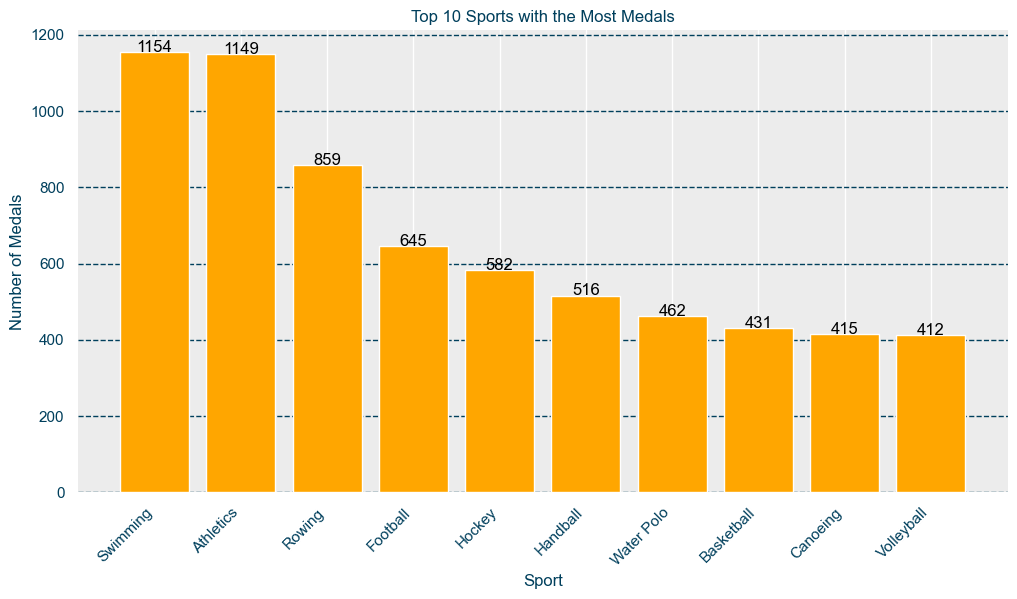

In [355] used -1.2 MiB RAM in 0.26s (system mean cpu 3%, single max cpu 100%), peaked 5.1 MiB above final usage, current RAM usage now 527.2 MiB


In [355]:
top_10_sports = df.groupby('Sport')['Medal'].count().nlargest(10)

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(top_10_sports.index, top_10_sports.values, color='#ffa600')
ax.set_title('Top 10 Sports with the Most Medals', color='#003f5c')
ax.set_xlabel('Sport', color='#003f5c')
ax.set_ylabel('Number of Medals', color='#003f5c')
ax.tick_params(axis='both', colors='#003f5c')
ax.grid(axis='y', linestyle='--', color='#003f5c')

for i, sport in enumerate(top_10_sports.index):
    ax.text(i, top_10_sports[sport] + 0.5, str(top_10_sports[sport]), color='black', ha='center')

plt.xticks(rotation=45, ha='right')
plt.show()


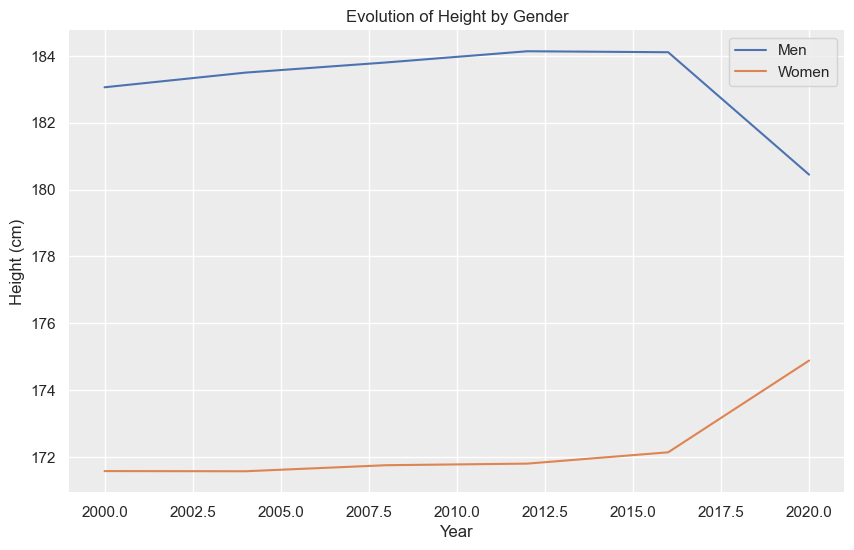

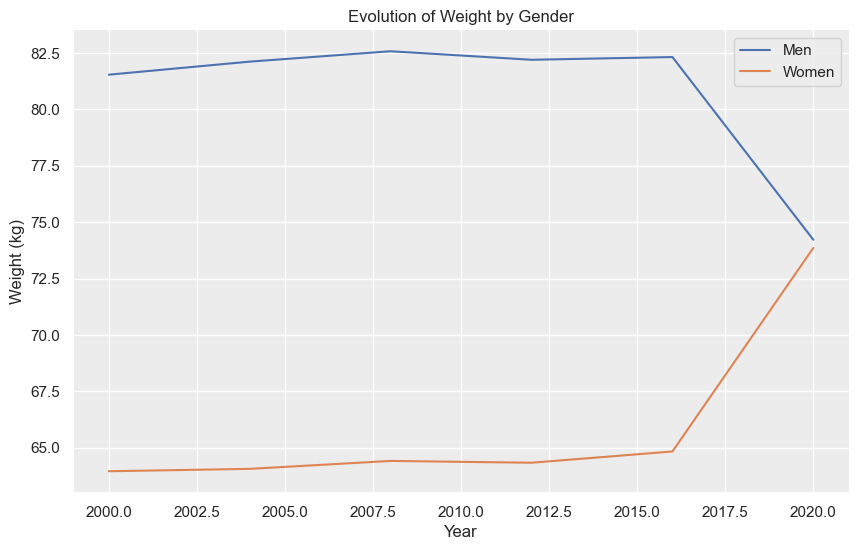

In [356] used 4.4 MiB RAM in 0.47s (system mean cpu 10%, single max cpu 100%), peaked 4.1 MiB above final usage, current RAM usage now 531.6 MiB


In [356]:
import pandas as pd
import matplotlib.pyplot as plt

# Suppose you have your data in a DataFrame named 'df'

# Filter data for men and women separately
men_data = df[df['Sex'] == 'M']
women_data = df[df['Sex'] == 'F']

# Group data by year and calculate the average height and weight for men and women
men_height_weight = men_data.groupby('Year')[['Height', 'Weight']].mean()
women_height_weight = women_data.groupby('Year')[['Height', 'Weight']].mean()

# Plot the evolution of height for men and women
plt.figure(figsize=(10, 6))
plt.plot(men_height_weight.index, men_height_weight['Height'], label='Men')
plt.plot(women_height_weight.index, women_height_weight['Height'], label='Women')

plt.title('Evolution of Height by Gender')
plt.xlabel('Year')
plt.ylabel('Height (cm)')
plt.legend()
plt.grid(True)
plt.show()

# Plot the evolution of weight for men and women
plt.figure(figsize=(10, 6))
plt.plot(men_height_weight.index, men_height_weight['Weight'], label='Men')
plt.plot(women_height_weight.index, women_height_weight['Weight'], label='Women')

plt.title('Evolution of Weight by Gender')
plt.xlabel('Year')
plt.ylabel('Weight (kg)')
plt.legend()
plt.grid(True)
plt.show()
